# IMPORTING LIBRARIES

In [72]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

# LOADING DATA

In [73]:
data = pd.read_csv("/content/bangladesh_weather_2011_2024.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2011-01-01,Dhaka,17.5,21.6,0.3,2.9,6.5,W,29.2,N,...,82.1,81.1,1007.8,1006.9,0,8,18.9,19.9,No,Yes
1,2011-01-01,Chittagong,11.0,22.0,0.7,6.9,9.5,S,13.0,NW,...,70.5,59.3,1006.6,1009.6,2,3,18.3,15.9,No,No
2,2011-01-01,Sylhet,14.7,23.1,3.7,6.7,5.9,NE,9.2,E,...,76.3,73.2,1010.7,1011.8,4,1,18.0,20.6,Yes,No
3,2011-01-01,Rajshahi,16.9,22.4,7.6,6.9,0.1,SW,22.4,E,...,67.2,74.8,1007.0,1010.9,0,8,20.0,21.6,Yes,No
4,2011-01-01,Khulna,10.8,25.2,0.3,4.2,6.5,SW,29.4,NW,...,92.3,84.7,1009.3,1006.5,7,0,12.7,18.3,No,No


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35798 entries, 0 to 35797
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           35798 non-null  object 
 1   Location       35798 non-null  object 
 2   MinTemp        35798 non-null  float64
 3   MaxTemp        35798 non-null  float64
 4   Rainfall       35798 non-null  float64
 5   Evaporation    35798 non-null  float64
 6   Sunshine       35798 non-null  float64
 7   WindGustDir    35798 non-null  object 
 8   WindGustSpeed  35798 non-null  float64
 9   WindDir9am     35798 non-null  object 
 10  WindDir3pm     35798 non-null  object 
 11  WindSpeed9am   35798 non-null  float64
 12  WindSpeed3pm   35798 non-null  float64
 13  Humidity9am    35798 non-null  float64
 14  Humidity3pm    35798 non-null  float64
 15  Pressure9am    35798 non-null  float64
 16  Pressure3pm    35798 non-null  float64
 17  Cloud9am       35798 non-null  int64  
 18  Cloud3

# DATA VISUALIZATION AND CLEANING

<Axes: xlabel='RainTomorrow', ylabel='count'>

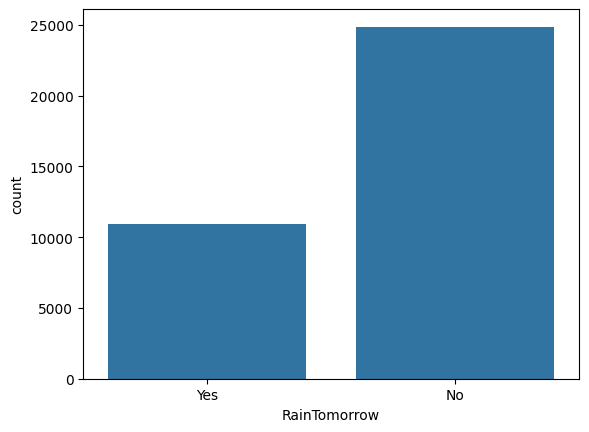

In [77]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
sns.countplot(x= data["RainTomorrow"])

In [51]:
# # Correlation amongst numeric attributes
# corrmat = data.corr()
# cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
# plt.subplots(figsize=(18,18))
# sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [78]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

,count
Date,
10,35798


In [79]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2011-01-01,Dhaka,17.5,21.6,0.3,2.9,6.5,W,29.2,N,...,19.9,No,Yes,2011,1,0.5,0.866025,1,0.201299,0.97953
1,2011-01-01,Chittagong,11.0,22.0,0.7,6.9,9.5,S,13.0,NW,...,15.9,No,No,2011,1,0.5,0.866025,1,0.201299,0.97953
2,2011-01-01,Sylhet,14.7,23.1,3.7,6.7,5.9,NE,9.2,E,...,20.6,Yes,No,2011,1,0.5,0.866025,1,0.201299,0.97953
3,2011-01-01,Rajshahi,16.9,22.4,7.6,6.9,0.1,SW,22.4,E,...,21.6,Yes,No,2011,1,0.5,0.866025,1,0.201299,0.97953
4,2011-01-01,Khulna,10.8,25.2,0.3,4.2,6.5,SW,29.4,NW,...,18.3,No,No,2011,1,0.5,0.866025,1,0.201299,0.97953


Text(0.5, 0, 'Days In Year')

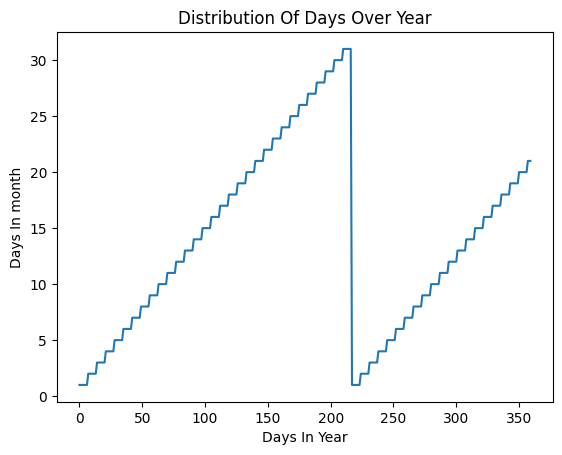

In [80]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot()
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

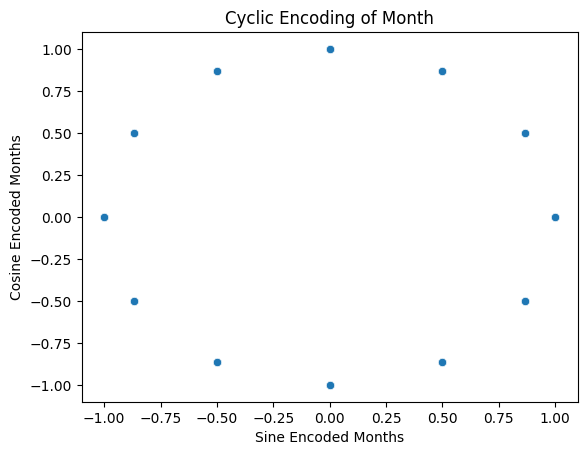

In [81]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data)
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

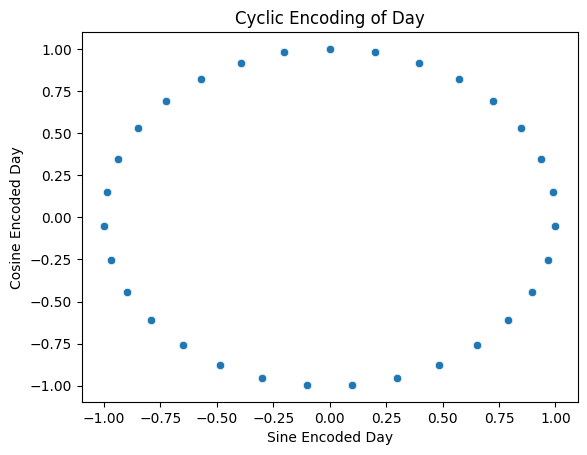

In [83]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data)
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

**Categorical variables**

* Filling missing values with mode of the column value

In [84]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [85]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0
RainTomorrow 0


In [86]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

/tmp/ipython-input-1733177674.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].mode()[0], inplace=True)


**Numerical variables**

* Filling missing values with median of the column value

In [87]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [88]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 0
MaxTemp 0
Rainfall 0
Evaporation 0
Sunshine 0
WindGustSpeed 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
Temp9am 0
Temp3pm 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [89]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35798 entries, 0 to 35797
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           35798 non-null  datetime64[ns]
 1   Location       35798 non-null  object        
 2   MinTemp        35798 non-null  float64       
 3   MaxTemp        35798 non-null  float64       
 4   Rainfall       35798 non-null  float64       
 5   Evaporation    35798 non-null  float64       
 6   Sunshine       35798 non-null  float64       
 7   WindGustDir    35798 non-null  object        
 8   WindGustSpeed  35798 non-null  float64       
 9   WindDir9am     35798 non-null  object        
 10  WindDir3pm     35798 non-null  object        
 11  WindSpeed9am   35798 non-null  float64       
 12  WindSpeed3pm   35798 non-null  float64       
 13  Humidity9am    35798 non-null  float64       
 14  Humidity3pm    35798 non-null  float64       
 15  Pressure9am    3579

/tmp/ipython-input-1421615967.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna(data[i].median(), inplace=True)


Text(0.5, 0, 'Years')

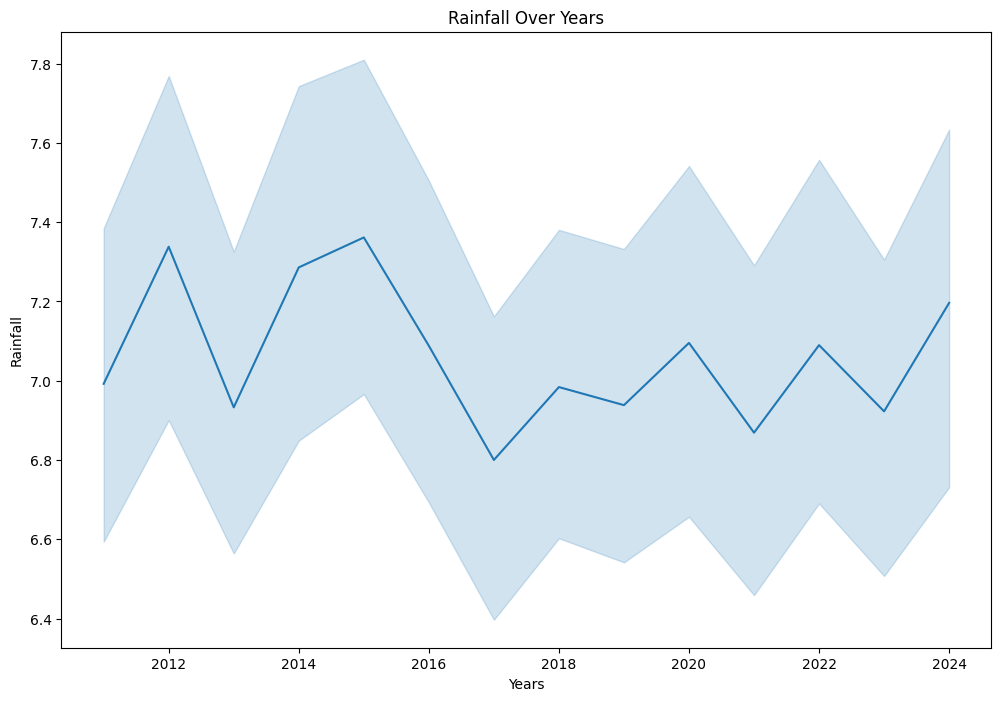

In [90]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data)
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

/tmp/ipython-input-1618510900.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None)


Text(0.5, 0, 'Year')

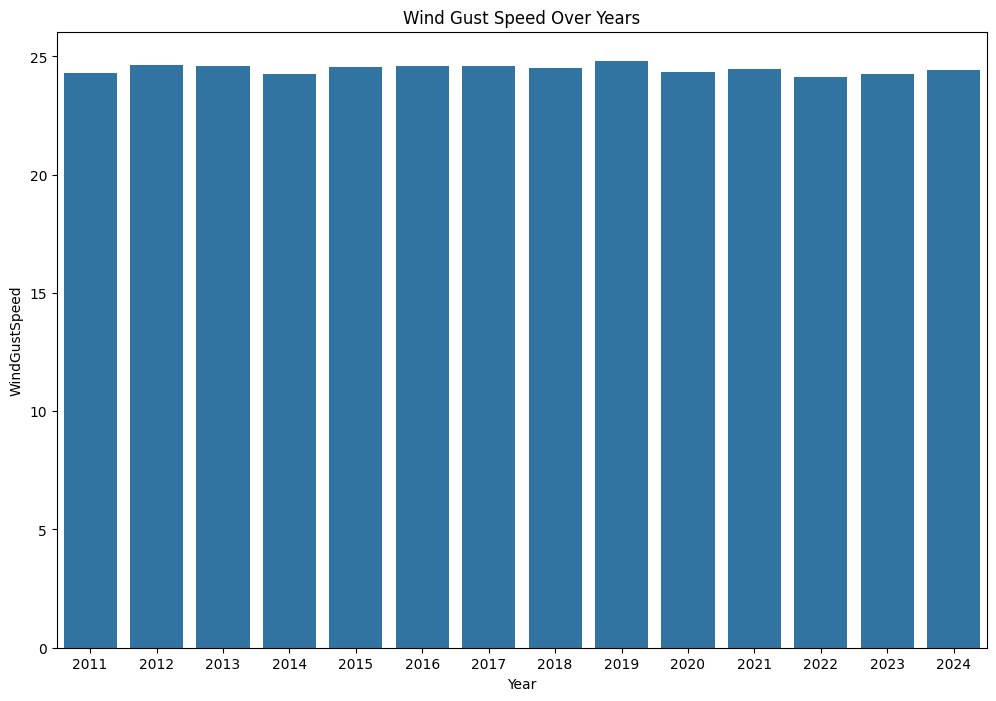

In [91]:
#Evauating Wind gust speed over years
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

# DATA PREPROCESSING

**Label encoding the catagorical varable**

In [92]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35798 entries, 0 to 35797
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           35798 non-null  datetime64[ns]
 1   Location       35798 non-null  int64         
 2   MinTemp        35798 non-null  float64       
 3   MaxTemp        35798 non-null  float64       
 4   Rainfall       35798 non-null  float64       
 5   Evaporation    35798 non-null  float64       
 6   Sunshine       35798 non-null  float64       
 7   WindGustDir    35798 non-null  int64         
 8   WindGustSpeed  35798 non-null  float64       
 9   WindDir9am     35798 non-null  int64         
 10  WindDir3pm     35798 non-null  int64         
 11  WindSpeed9am   35798 non-null  float64       
 12  WindSpeed3pm   35798 non-null  float64       
 13  Humidity9am    35798 non-null  float64       
 14  Humidity3pm    35798 non-null  float64       
 15  Pressure9am    3579

In [93]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,35798.0,0.000000e+00,1.000014,-1.500000,-1.000000,0.000000,1.000000,1.500000
MinTemp,35798.0,-7.606011e-16,1.000014,-2.376638,-0.408620,0.390278,0.741014,1.130720
MaxTemp,35798.0,-2.286567e-16,1.000014,-2.237622,-0.564010,0.126355,0.670279,1.946408
Rainfall,35798.0,-3.572761e-17,1.000014,-0.656685,-0.545130,-0.359205,0.068422,14.124360
Evaporation,35798.0,2.709344e-17,1.000014,-1.735993,-0.869773,-0.003552,0.862668,1.728889
Sunshine,35798.0,-4.366708e-16,1.000014,-1.917293,-0.783722,-0.080125,0.740737,1.991575
WindGustDir,35798.0,-7.661587e-17,1.000014,-1.523687,-1.088355,-0.217690,1.088306,1.523639
WindGustSpeed,35798.0,-2.516812e-16,1.000014,-1.640968,-0.823149,-0.055917,0.728178,2.996149
WindDir9am,35798.0,-1.488650e-17,1.000014,-1.524930,-1.089180,0.218070,1.089570,1.525320
WindDir3pm,35798.0,8.733415e-18,1.000014,-1.532563,-0.659620,0.213322,1.086264,1.522736


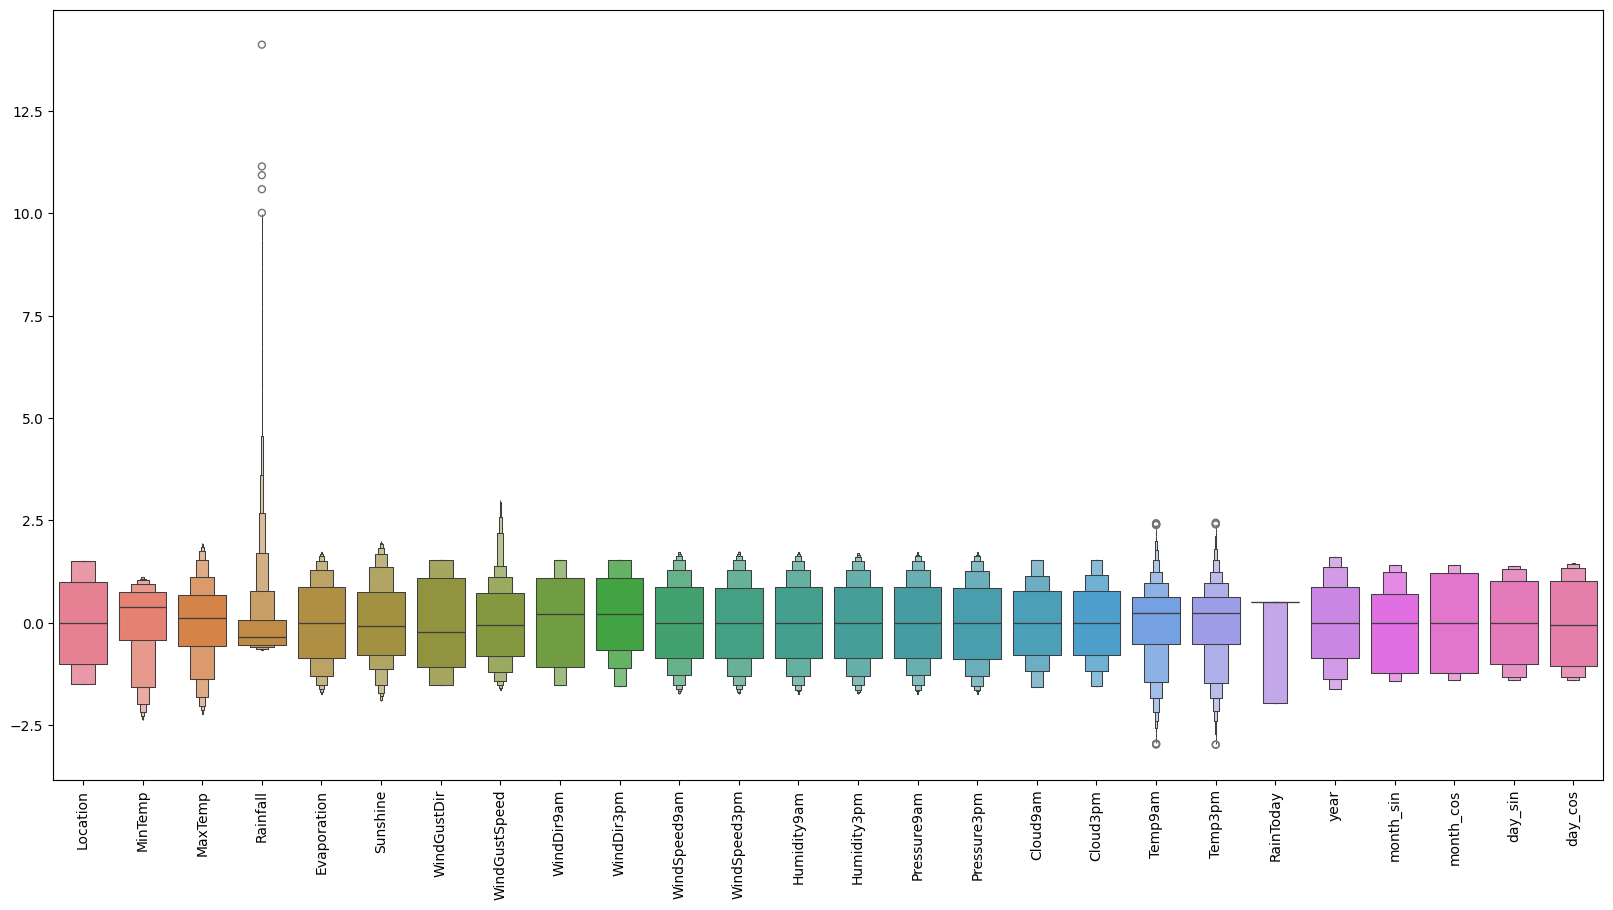

In [95]:
#Detecting outliers
#looking at the scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [96]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(31962, 27)

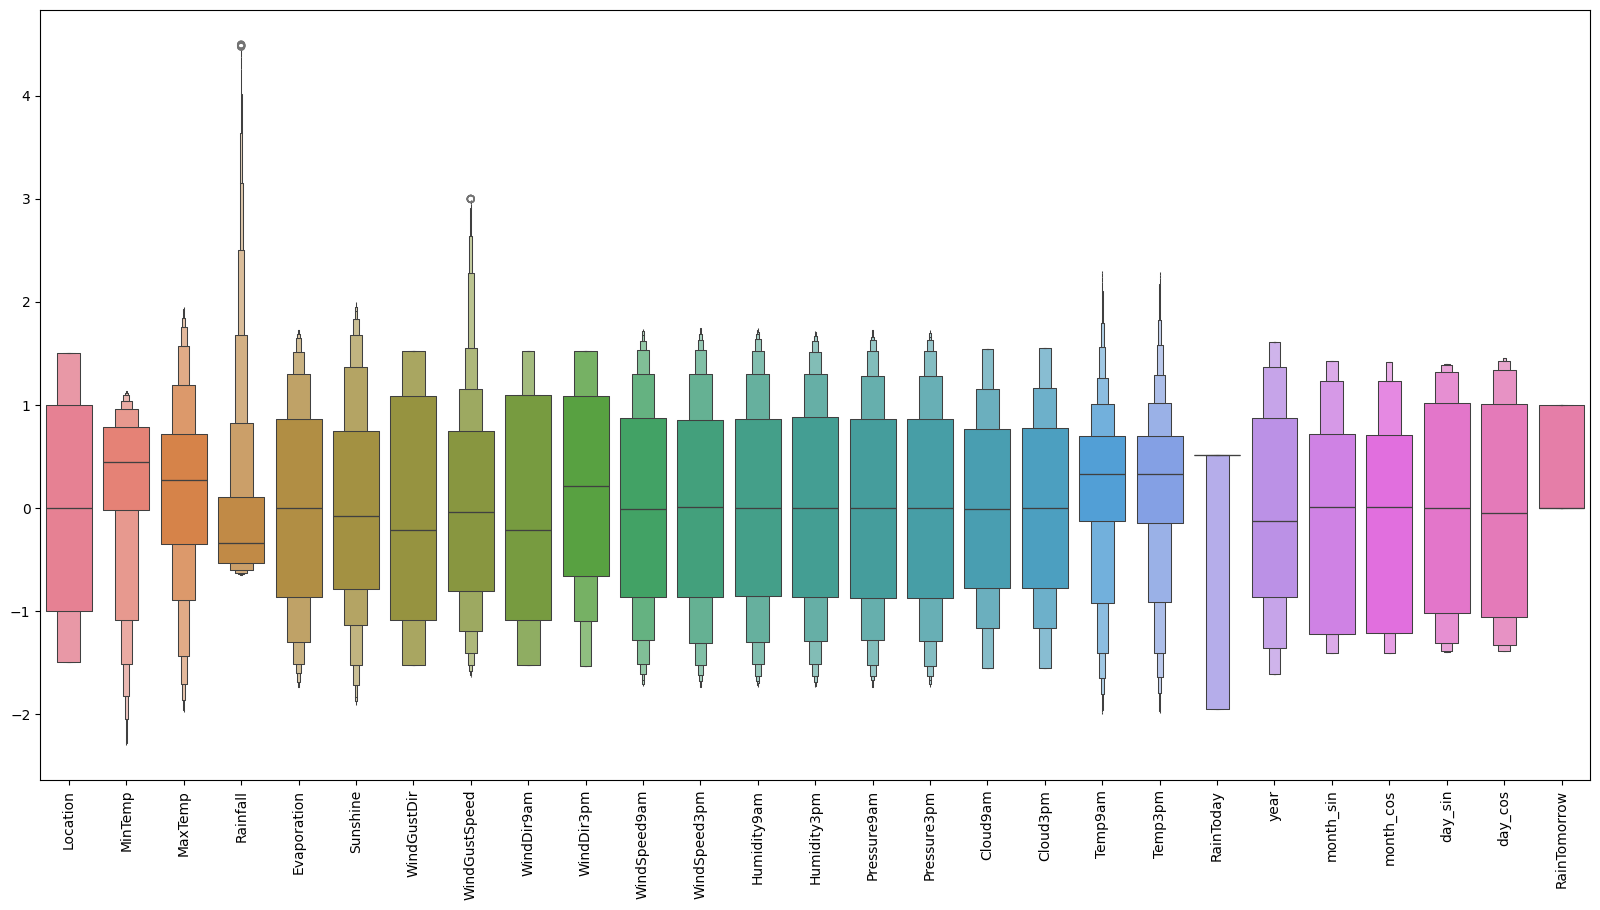

In [97]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

# MODEL BUILDING

In [98]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(31962, 26)

In [99]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6915 - loss: 0.6867 - val_accuracy: 0.7004 - val_loss: 0.6286
Epoch 2/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6968 - loss: 0.6327 - val_accuracy: 0.7004 - val_loss: 0.6168
Epoch 3/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6925 - loss: 0.6336 - val_accuracy: 0.7004 - val_loss: 0.6150
Epoch 4/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6922 - loss: 0.6293 - val_accuracy: 0.7004 - val_loss: 0.6148
Epoch 5/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6877 - loss: 0.6303 - val_accuracy: 0.7004 - val_loss: 0.6139
Epoch 6/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6915 - loss: 0.6278 - val_accuracy: 0.7004 - val_loss: 0.6133
Epoch 7/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6964 - loss: 0.6219 - val_accuracy: 0.7004 - val_loss: 0.6137
Epoch 8/150
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6940 - loss: 0.6223 - val_accuracy: 0.7004

Plotting training and validation loss over epochs

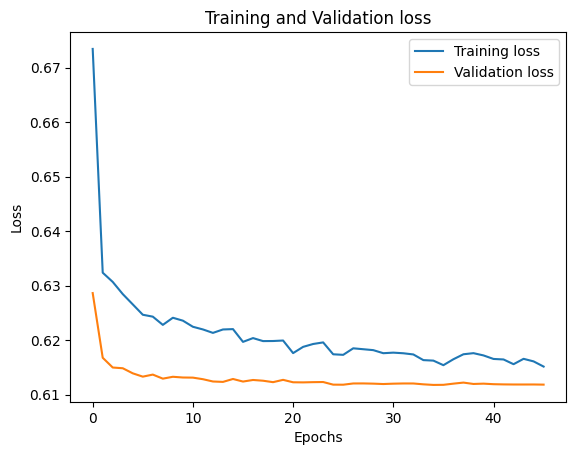

In [100]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs

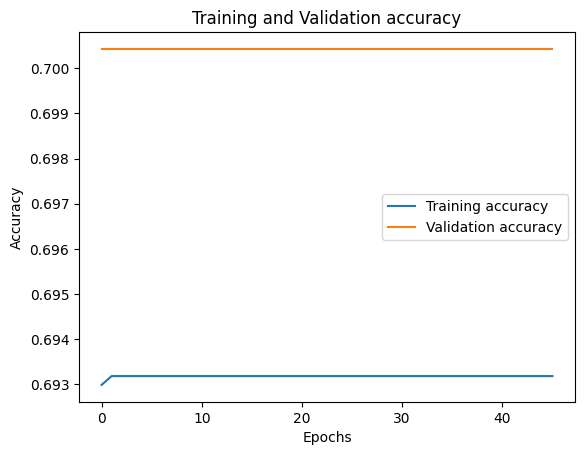

In [101]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CONCLUSIONS

In [102]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

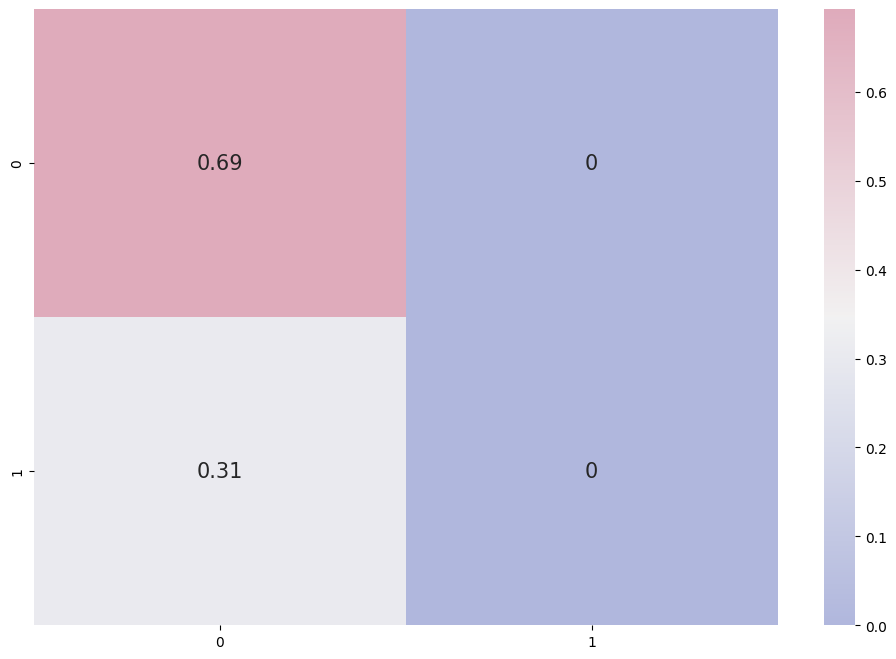

In [103]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      4430
           1       0.00      0.00      0.00      1963

    accuracy                           0.69      6393
   macro avg       0.35      0.50      0.41      6393
weighted avg       0.48      0.69      0.57      6393



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
